In [1]:
import math
%matplotlib inline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import eli5
import os
import pickle
import numpy as np
import pandas as pd
import time
from contextlib import contextmanager
from scipy.sparse import hstack, vstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, StratifiedKFold, train_test_split, validation_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.svm import SVC 

In [2]:
#train_df = pd.read_csv('Desktop/dataset/train_sessions.csv')
#ind = int(train_df.shape[0] * .7)
#train_df = train_df.sort_values(by='time1')
#X_train = train_df[:ind]
#X_test = train_df[ind:]
#X_train.to_csv('Desktop/dataset/alice/train.csv')
#X_test.to_csv('Desktop/dataset/alice/test.csv')

In [2]:
PATH_TO_DATA = 'Desktop/dataset/'
AUTHOR = 'Alex_Elchaninov' # change here to <name>_<surname>
# it's a nice practice to define most of hyperparams here
SEED = 17
N_JOBS = 4
NUM_TIME_SPLITS = 10    # for time-based cross-validation
SITE_NGRAMS = (1, 5)    # site ngrams for "bag of sites"
MAX_FEATURES = 50000    # max features for "bag of sites"
BEST_LOGIT_C = 5.45559

In [3]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
test_df = pd.read_csv('Desktop/dataset/test_sessions.csv',index_col='session_id', parse_dates=times)
train_df = pd.read_csv('Desktop/dataset/train_sessions.csv',index_col='session_id', parse_dates=times)
#y_test = test_df['target']
#test_df.drop('target', axis = 1, inplace = True)
#test_df.drop('Unnamed: 0', axis = 1, inplace = True)
#train_df.drop('Unnamed: 0', axis = 1, inplace = True)
train_df = train_df.sort_values(by='time1')
alice_sites = [80,77,76, 81, 879, 82, 75, 82]
y_train = train_df['target']

In [5]:
def prepare_sparse_features(train_df, test_df, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = train_df.sort_values(by='time1')
    with open(r"Desktop/dataset/site_dic.pkl", "rb") as input_file:
        site_dict = pickle.load(input_file)
    id2sites = {i:k for k,i in site_dict.items()}
    id2sites[0] = 'unknown'
    sites = ['site%s' % i for i in range(1, 11)]
    train_session = train_df[sites].fillna(0).astype(int).apply(lambda row:
                                                                ' '.join([id2sites[i] for i in row]), axis = 1).tolist()
    test_session = test_df[sites].fillna(0).astype(int).apply(lambda row:
                                                                ' '.join([id2sites[i] for i in row]), axis = 1).tolist()
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_session)
    X_test = vectorizer.transform(test_session)
    y_train = train_df['target'].astype(int).values
    train_times, test_times = train_df[times], test_df[times]
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [6]:
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = \
        prepare_sparse_features(train_df,test_df,
            path_to_site_dict=os.path.join('Desktop/dataset/site_dic.pkl'),
            vectorizer_params={'ngram_range': SITE_NGRAMS,
                               'max_features': MAX_FEATURES,
                               'tokenizer': lambda s: s.split()})
                                


In [7]:
def onehot (a):
    return OneHotEncoder(sparse = True).fit_transform(np.array(a).reshape(-1,1))

In [8]:
def add_features(times):
    hour = times['time1'].apply(lambda ts: ts.hour).values.reshape(-1, 1)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').reshape(-1, 1)
#    night = ((hour >= 0) & (hour <= 6)).astype('int').reshape(-1, 1)
    sess_duration = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[s]')\
		   .astype('int').values.reshape(-1, 1)
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
#    day_of_week_onehot = onehot(day_of_week)
    weekend = np.array(times['time1'].apply(lambda t: t.weekday()).isin([5,6]).astype('int')).reshape(-1,1)
    X = np.hstack([morning, day, evening, sess_duration, day_of_week, 
                   month, year_month])
    return X

In [8]:
def scaled (x_train, x_test, c = 1):
    if c == 1:
        scaler = StandardScaler()
    else:
        scaler = MaxAbsScaler()
    x_train_new = scaler.fit_transform(x_train.reshape(-1,1))
    x_test_new = scaler.transform(x_test.reshape(-1,1))
    return x_train_new.reshape(-1), x_test_new.reshape(-1)

In [7]:
def scaled_pd (x_train, x_test, c = 1):
    if c == 1:
        scaler = StandardScaler()
    else:
        scaler = MaxAbsScaler()
    x_train_new = scaler.fit_transform(x_train.values.reshape(-1,1))
    x_test_new = scaler.transform(x_test.values.reshape(-1,1))
    return x_train_new, x_test_new

In [11]:
def onehot_array (x_train, x_test):
    train_final = []
    categorial = x_train.columns
    for i in categorial:
        a = OneHotEncoder(sparse = False).fit(np.array(x_train[i]).reshape(-1,1))
        train = a.transform(np.array(x_train[i]).reshape(-1,1))
        test = a.transform(np.array(x_test[i]).reshape(-1,1))
        if len(train_final) == 0:
            train_final = train
            test_final = test
        else:
            train_final = np.hstack([train_final,train])
            test_final = np.hstack([test_final,test] )    
    return train_final, test_final

In [12]:
def scaled_one_array (x_train):
    scaler = StandardScaler()
    x_train_new = scaler.fit_transform(np.array(x_train).reshape(-1,1))
    return x_train_new.reshape(-1)

In [13]:
def check_site (s):
    if s in alice_sites:
        return 1
    else:
        return 0

In [14]:
def alice_prefer (x_train, x_test):
    new_feat_train = 0
    new_feat_test = 0
    for i in sites:
            new_feat_train += train_df[i].apply(check_site).astype(int)
            new_feat_test += test_df[i].apply(check_site).astype(int)
    new_feat_train_boolean = (new_feat_train > 0).astype(int)
    new_feat_test_boolean = (new_feat_test > 0).astype(int)
    new_train = np.hstack([np.array(new_feat_train).reshape(-1,1),np.array(new_feat_train_boolean).reshape(-1,1)])
    new_test = np.hstack([np.array(new_feat_test).reshape(-1,1),np.array(new_feat_test_boolean).reshape(-1,1)])
    return new_train, new_test

In [8]:
def times_features (times):
    new_features_time = pd.DataFrame()
    new_features_time['hour'] = times['time1'].apply(lambda ts: ts.hour)
    new_features_time['morning'] = ((new_features_time['hour'] >= 7) & (new_features_time['hour'] <= 11)).astype('int')
    new_features_time['day'] = ((new_features_time['hour'] >= 12) & (new_features_time['hour'] <= 18)).astype('int')
    new_features_time['evening'] = ((new_features_time['hour'] >= 19) & (new_features_time['hour'] <= 23)).astype('int')
    new_features_time['sess_duration'] = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[s]')\
		   .astype('int')
    new_features_time['day_of_week'] = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
#    new_features_time['weekend'] = times['time1'].apply(lambda t: t.weekday()).isin([5,6]).astype('int')
    new_features_time['month'] = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    new_features_time['year_month'] = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    new_features_time.drop('hour', axis = 1, inplace = True)
#    new_features_time= pd.concat([new_features_time,
#                           pd.get_dummies(new_features_time['hour'], 
#                                          prefix = "hour")], axis = 1)
#    hour_onehot = onehot(hour)
#    day_of_week_onehot = onehot(day_of_week)
#    month_onehot = onehot(month)   

    return new_features_time


In [9]:
train_features = times_features(train_times)
test_features = times_features(test_times)

In [74]:
train_features.shape

(253561, 8)

In [75]:
alice_train, alice_test = alice_prefer(X_train_sites, X_test_sites)

In [85]:
train_features['alice'] = alice_train[:,0]
test_features['alice'] = alice_test[:,0]
train_features['alice_bool'] = alice_train[:,1]
test_features['alice_bool'] = alice_test[:,1]


In [10]:
def scaler_cv (train_features,test_features):
    index_scalar = []
    for i in train_features.columns:
        if train_features[i].max() > 1:
            index_scalar.append(i)
    for i in index_scalar:
        train_features[i] , test_features[i] = scaled_pd(train_features[i],test_features[i])
    return train_features, test_features

In [11]:
train_features, test_features = scaler_cv (train_features,test_features)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted

In [70]:
mean = {}
for i in train_features.columns:
    train_features1 = train_features.drop(i,axis = 1)
    test_features1 = test_features.drop(i,axis = 1)
    X_train_final1 = hstack([X_train_sites,np.array(train_features1)])
    X_test_final1 = hstack([X_test_sites,np.array(test_features1)])
    mean_score = cross_val_score(LogisticRegression(C = 3.9810717055349722, random_state=SEED), X_train_final1,
                             y_train, scoring = 'roc_auc', cv = time_split)
    mean[i] = mean_score[len(mean_score)-1]
    

In [71]:
mean

{'hour': 0.9697412278251631,
 'morning': 0.9793495070842853,
 'day': 0.979294379320179,
 'evening': 0.9790968994185367,
 'sess_duration': 0.9791881971212038,
 'day_of_week': 0.9746589306487827,
 'weekend': 0.9798900041848098,
 'month': 0.979159561310404,
 'year_month': 0.9790748483128944,
 'alice': 0.9794252771333956,
 'alice_bool': 0.9792791273054431}

In [ ]:
index_scalar = []
for i in range(train_features.shape[1]):
    if train_features[i].max() > 1:
        index_scalar.append(i)
for i in index_scalar:
    train_features[:,i] , test_features[:,i] = scaled(train_features[:,i],test_features[:,i])

In [15]:
train_features.head()

,morning,day,evening,sess_duration,day_of_week,month,year_month
session_id,,,,,,,
21669,1,0,0,-0.468233,1.682905,-0.943567,-1.744405
54843,1,0,0,5.570015,1.682905,-0.943567,-1.744405
77292,1,0,0,-0.454709,1.682905,-0.943567,-1.744405
114021,1,0,0,-0.458090,1.682905,-0.943567,-1.744405
146670,1,0,0,-0.461471,1.682905,-0.943567,-1.744405


In [12]:
X_train_final = hstack([X_train_sites,np.array(train_features)])
X_test_final = hstack([X_test_sites,np.array(test_features)])

In [13]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
time_split = TimeSeriesSplit(n_splits=10)

In [14]:
mean_score = cross_val_score(SGDClassifier(penalty = 'elasticnet', l1_ratio = .275,
                                           alpha = 1e-06,loss = 'log', random_state=SEED), 
                             X_train_final,
                             y_train, scoring = 'roc_auc', cv = time_split)
print (mean_score)
print(mean_score.mean())

[0.83809471 0.81855623 0.91753676 0.9662976  0.92455903 0.94732148
 0.95049932 0.94821019 0.96223522 0.94605427]
0.9219364821961301


In [23]:
LogisticRegression?

In [34]:
mean_score = cross_val_score(LogisticRegression(penalty = 'l2', max_iter = 100, 
                                                random_state=SEED),
                            X_train_final,
                             y_train, scoring = 'roc_auc', cv = time_split, n_jobs = -1)   
print (mean_score)
print(mean_score.mean())

[0.61280832 0.94680807 0.9449874 ]
0.8348679306757485


In [ ]:
mean_score = cross_val_score(SVC(gamma = .05, random_state=SEED),
                            X_train_final,
                             y_train, scoring = 'roc_auc', cv = time_split, n_jobs = -1)   
print (mean_score)
print(mean_score.mean())

In [15]:
SVC?

In [27]:
0.9192840504075726 C = 3.9810717055349722,

0.9192840504075726

In [171]:
np.linspace(10**-5,10**-4,3)

array([1.0e-05, 5.5e-05, 1.0e-04])

In [48]:
np.linspace(1,0.01,3)

array([1.   , 0.505, 0.01 ])

In [50]:
params = {'C' : np.linspace(3,0.5,3),
         'gamma' : np.linspace(1,0.01,3)}
logit = SVC(kernel='linear',random_state=SEED)
best_c = GridSearchCV(logit,params, cv =time_split, n_jobs=-1, scoring='roc_auc')

In [51]:
%%time
best_c.fit(X_train_final, y_train)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\execution.py", line 1284, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 1, in <module>
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 722, in fit
    self._run_search(evaluate_candidates)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1191, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 711, in evaluate_candidates
    cv.split(X, y, groups)))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line 930, in __call__
    self.retrieve()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line 833, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "C:\Pro

KeyboardInterrupt: 

In [54]:
best_c

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=17,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([3.  , 1.75, 0.5 ]), 'gamma': array([1.   , 0.505, 0.01 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [115]:
logit = LogisticRegression(random_state=SEED, C = 3.9810717055349722)
logit.fit(X_train_final,y_train)
test_pred = logit.predict_proba(X_test_final)[:,1]
pd.Series(test_pred,
          index = range (1,test_pred.shape[0] + 1) ,
          name = 'target').to_csv('Desktop/dataset/benchmark.csv', header = True,
                                 index_label = 'session_id')

In [99]:
train_features.shape

(253561, 10)

In [100]:
pd.DataFrame({'features': train_features.columns, 'coef':logit.coef_.flatten()[-10:]})

,features,coef
0,morning,-1.769467
1,day,0.356269
2,evening,-5.783532
3,sess_duration,-0.223912
4,day_of_week,-0.494180
5,weekend,-0.228544
6,month,0.218107
7,year_month,-0.397726
8,alice,0.141244
9,alice_bool,0.163639


In [46]:
train_score, test_score = validation_curve(LogisticRegression(random_state=SEED),
                                                             X_train_final, y_train,
                                                             param_name = 'C', 
                                                             param_range = c_values,
                                                             cv = time_split.split(X_train_final, y_train),
                                                             scoring = 'roc_auc')

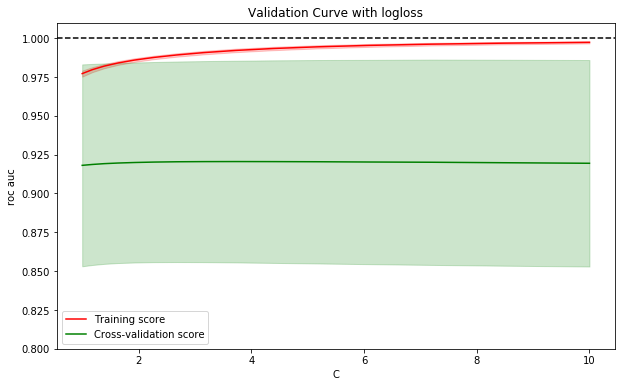

In [50]:
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)

fig = plt.figure(figsize=(10, 6))

plt.title("Validation Curve with logloss")
plt.xlabel("C")
plt.ylabel("roc auc")


plt.plot(c_values,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(c_values,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(c_values, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(c_values,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")
plt.ylim(0.8, 1.01)

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")

# Бустинг

In [103]:
def times_features (times):
    new_features_time = pd.DataFrame()
    new_features_time['hour'] = times['time1'].apply(lambda ts: ts.hour)
    new_features_time['morning'] = ((new_features_time['hour'] >= 7) & (new_features_time['hour'] <= 11)).astype('int')
    new_features_time['day'] = ((new_features_time['hour'] >= 12) & (new_features_time['hour'] <= 18)).astype('int')
    new_features_time['evening'] = ((new_features_time['hour'] >= 19) & (new_features_time['hour'] <= 23)).astype('int')
    new_features_time['sess_duration'] = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[s]')\
		   .astype('int')
    new_features_time['day_of_week'] = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    new_features_time['month'] = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    new_features_time['year_month'] = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
#    new_features_time.drop('hour', axis = 1, inplace = True)
#    new_features_time= pd.concat([new_features_time,
#                           pd.get_dummies(new_features_time['hour'], 
#                                          prefix = "hour")], axis = 1)
#    hour_onehot = onehot(hour)
#    day_of_week_onehot = onehot(day_of_week)
#    month_onehot = onehot(month)                       
    return new_features_time

In [104]:
def interaction_features (times):
    categories = times.columns
    for i, col1 in enumerate(categories):
        for j, col2 in enumerate(categories[i + 1:]):
            times[col1 + '_' + col2] = times[col1].astype('str') + '_' + times[col2].astype('str')
    return times

In [139]:
train_times_features = times_features (train_times)
test_times_features = times_features (test_times)
#train_times_for_meantarget = times_features_mean_array(train_times)
#test_times_for_meantarget = times_features_mean_array(test_times)

In [140]:
full_times_features = pd.concat([train_times_features,test_times_features])
index = train_times_features.shape[0]
full_times_features = full_times_features.fillna(0).astype('int')
full_times_features_interaction = interaction_features(full_times_features.drop('sess_duration', axis = 1))
full_times_features_interaction['sess_duration'] = full_times_features['sess_duration']

In [141]:
full_times_features_interaction_for_xgb = pd.concat([full_times_features_interaction, 
          pd.get_dummies(full_times_features_interaction['month'], prefix = 'month'),
          pd.get_dummies(full_times_features_interaction['day_of_week'], prefix = 'day_of_week')], axis = 1)

In [25]:
np.where((train_times_features.dtypes == 'int64') | (train_times_features.dtypes == 'int32'))[0].tolist()

[0, 1, 2, 3, 4, 5, 6]

In [26]:
train_times_features.shape

(253561, 28)

In [142]:
label_incoder = LabelEncoder()
for col in full_times_features_interaction.columns:
    full_times_features_interaction[col] = label_incoder.fit_transform(full_times_features_interaction[col])
label_incoder = LabelEncoder()
for col in full_times_features_interaction_for_xgb.columns:
    full_times_features_interaction_for_xgb[col] = label_incoder.fit_transform(full_times_features_interaction_for_xgb[col])    

In [132]:
#for i in full_times_features_interaction_for_xgb.columns:
#    if (full_times_features_interaction_for_xgb[i].max() > 1) or (full_times_features_interaction_for_xgb[i].max() < .1):
#        scaler = StandardScaler()
#        full_times_features_interaction_for_xgb[i] = scaler.fit_transform(full_times_features_interaction_for_xgb[i].values.reshape(-1,1))

In [80]:
a=[]
for i in full_times_features_interaction.columns:
    if (full_times_features_interaction[i].max() > 1) or (full_times_features_interaction[i].max() < .1):
        a.append(i)
        scaler = StandardScaler()
        full_times_features_interaction[i] = scaler.fit_transform(full_times_features_interaction[i].values.reshape(-1,1))

In [81]:
a

['day_of_week',
 'month',
 'year_month',
 'morning_day',
 'morning_evening',
 'morning_day_of_week',
 'morning_month',
 'day_day_of_week',
 'day_month',
 'evening_day_of_week',
 'evening_month',
 'day_of_week_month',
 'day_of_week_year_month',
 'month_year_month']

In [143]:
train_times_features = full_times_features_interaction[:index]
test_times_features = full_times_features_interaction[index:]
train_times_features_for_xgb = full_times_features_interaction_for_xgb[:index]
test_times_features_for_xgb = full_times_features_interaction_for_xgb[index:]

In [146]:
time_split = TimeSeriesSplit(n_splits=4)

In [28]:
train_df_fortarget = train_times_features
train_df_fortarget['y'] = pd.Series(y_train)
train_array = []
valid_array = []
new_feat_train = train_df_fortarget.copy()
for trainind, validind in time_split.split(train_times_features, y_train):
    train_array.append(trainind)
    valid_array.append(validind)
ind = train_array
ind.append(np.hstack([train_array[3],valid_array[3]]))
columns = ['hour', 'day_of_week']
for col in columns:
    new_feat_train[col +'_' + 'mean_target'] = y_train.mean()
for col in columns:
    train_cv  = new_feat_train.iloc[ind[0]]
    mean = train_cv[col].map(train_cv.groupby(col)['y'].mean())
    train_cv[col + '_' + 'mean_target'] = mean.fillna(y_train.mean())
    new_feat_train.iloc[ind[0]] = train_cv
    for i in range (1, len(ind)):
        train_cv  = new_feat_train.iloc[np.delete(ind[i],ind[i-1])]
        mean = train_cv[col].map(train_df_fortarget.iloc[ind[i]].groupby(col)['y'].mean())
        train_cv[col + '_' + 'mean_target'] = mean.fillna(y_train.mean())
        new_feat_train.iloc[np.delete(ind[i],ind[i-1])] = train_cv
for col in columns:
    mean = test_times_features[col].map(new_feat_train.groupby(col)['y'].mean())
    test_times_features[col + '_' + 'mean_target'] =mean.fillna(y_train.mean())  
new_feat_train.drop('y', axis = 1, inplace = True)
#test_times_features.drop( axis = 1, inplace = True)


In [ ]:
i = np.where(y_train == 1)
pd.Series(i).hist()

### логистическая регрессия

In [16]:
np.mean(y_train[:35000])

0.0194

In [229]:
np.mean(y_train)

0.00905896411514389

In [123]:
full_times_features_interaction_dummies = pd.get_dummies(full_times_features_interaction_for_xgb.drop('sess_duration', axis = 1), 
                                                         columns = full_times_features_interaction_for_xgb.columns.drop('sess_duration'))
train_times_features_for_log = full_times_features_interaction_dummies[:index]
test_times_features_for_log = full_times_features_interaction_dummies[index:]
train = csr_matrix(train_times_features_for_log)

In [122]:
mean_score = cross_val_score(LogisticRegression(C = 1, random_state=SEED),
                            train,
                             y_train, scoring = 'roc_auc', cv = time_split, n_jobs = -1)
print (mean_score)
print(mean_score.mean())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.56375166 0.8981044  0.85741547 0.94928032 0.81884787 0.95093287
 0.84280976 0.95788903 0.63085157 0.96772008]
0.8437603029201499


In [114]:
params = {'C' : np.linspace(0.9,10,30)}
logit = LogisticRegression(random_state=SEED)
best_c = GridSearchCV(logit,params, cv =time_split, n_jobs=-1, scoring='roc_auc')
best_c.fit(train,y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([ 0.9    ,  1.21379,  1.52759,  1.84138,  2.15517,  2.46897,
        2.78276,  3.09655,  3.41034,  3.72414,  4.03793,  4.35172,
        4.66552,  4.97931,  5.2931 ,  5.6069 ,  5.92069,  6.23448,
        6.54828,  6.86207,  7.17586,  7.48966,  7.80345,  8.11724,
        8.43103,  8.74483,  9.05862,  9.37241,  9.68621, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [532]:
logit = LogisticRegression(random_state=SEED, C = 1)
logit.fit(train,y_train)
test_pred = logit.predict_proba(test_times_features)[:,1]
pd.Series(test_pred,
          index = range (1,test_pred.shape[0] + 1) ,
          name = 'target').to_csv('Desktop/dataset/benchmark.csv', header = True,
                                 index_label = 'session_id')

### конец

In [72]:
dtrain = xgb.DMatrix(train_times_features, y_train)
dtest = xgb.DMatrix(test_times_features)

In [35]:
params = {
    'objective':'binary:logistic',
    'max_depth': 4,
    'silent': 1,
    'subsample':.9,
    'eta': 0.3
}
num_rounds = 30

In [44]:
xgb_cv = xgb.cv(params,dtrain,num_rounds,folds=time_split, metrics={'auc'},seed=SEED)

In [45]:
xgb_cv['test-auc-mean'].max()

0.8676802

In [47]:
np.argmax(xgb_cv['test-auc-mean'])

8

In [28]:
x_train_parth,x_valid,y_train_parth,y_valid = train_test_split(train_times_features, y_train, 
                                                              random_state = 18, test_size = .3,
                                                              shuffle = False)

In [26]:
cat = CatBoostClassifier(random_state = SEED, iterations = 50,  verbose=False)

In [27]:
cat_features_index = np.where((train_times_features.dtypes == 'int64') | (train_times_features.dtypes == 'int32'))[0].tolist()

In [29]:
cat.fit(x_train_parth, y_train_parth, cat_features = cat_features_index)

In [30]:
roc_auc_score(y_valid,cat.predict_proba(x_valid)[:,1])

0.932932558322296

In [32]:
cv_scores = []
for train_ind, valid_ind in time_split.split(train_times_features, y_train):
    train_cv, valid_cv = train_times_features.iloc[train_ind,:], train_times_features.iloc[valid_ind,:]
    y_train_cv, y_valid_cv = y_train[train_ind], y_train[valid_ind]
    cat.fit(train_cv, y_train_cv, cat_features = cat_features_index)
    cv_scores.append(roc_auc_score(y_valid_cv, cat.predict_proba(valid_cv)[:,1]))

In [33]:
print(cv_scores)
np.mean(cv_scores)

[0.5584634140396632, 0.8536994653793245, 0.7375655722168148, 0.751720507142547, 0.7890782505737619, 0.650344998414811, 0.8952670964919054, 0.7760167239502369, 0.7358799820219506, 0.7372659650438647]


0.748530197527488

In [106]:
cat.fit(train_times_features, y_train, cat_features = cat_features_index)
test_pred = cat.predict_proba(test_times_features)[:,1]
pd.Series(test_pred,
          index = range (1,test_pred.shape[0] + 1) ,
          name = 'target').to_csv('Desktop/dataset/benchmark.csv', header = True,
                                 index_label = 'session_id')

In [42]:
cv_scores = []
for train_ind, valid_ind in time_split.split(train_times_features, y_train):
    train_cv, valid_cv = train_times_features.iloc[train_ind,:], train_times_features.iloc[valid_ind,:]
    y_train_cv, y_valid_cv = y_train[train_ind], y_train[valid_ind]
    dtrain = xgb.DMatrix(train_cv, y_train_cv)
    dtest = xgb.DMatrix(valid_cv)
    xgb_model = xgb.train(params,dtrain,num_rounds)
    cv_scores.append(roc_auc_score(y_valid_cv, xgb_model.predict(dtest)))

In [43]:
print(cv_scores)
np.mean(cv_scores)

[0.576129856699403, 0.907091150558351, 0.8129109385534643, 0.9564749685206895, 0.913792586104826, 0.9664584316225854, 0.8108471353563431, 0.9577904467167719, 0.6767466979832689, 0.9256897872391355]


0.8503931999354839

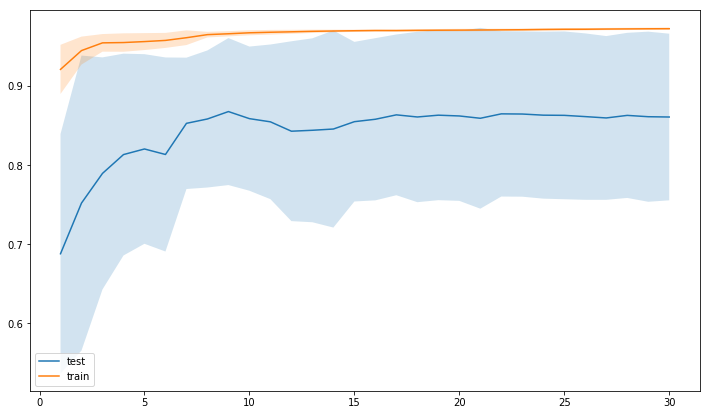

In [48]:
plt.figure(figsize  = (12,7))
plt.plot(range(1,xgb_cv.shape[0]+1), xgb_cv['test-auc-mean'], label = 'test')
plt.plot(range(1,xgb_cv.shape[0]+1), xgb_cv['train-auc-mean'], label = 'train')
plt.fill_between(range(1,xgb_cv.shape[0]+1),xgb_cv['test-auc-mean']-xgb_cv['test-auc-std'],
                xgb_cv['test-auc-mean']+xgb_cv['test-auc-std'], alpha = .2)
plt.fill_between(range(1,xgb_cv.shape[0]+1),xgb_cv['train-auc-mean']-xgb_cv['train-auc-std'],
                xgb_cv['train-auc-mean']+xgb_cv['train-auc-std'], alpha = .2)
plt.legend()

In [54]:
xgb_model = xgb.train(params,dtrain,num_rounds)

In [70]:
test_pred = xgb_model.predict(dtest)
pd.Series(test_pred,
          index = range (1,test_pred.shape[0] + 1) ,
          name = 'target').to_csv('Desktop/dataset/benchmark.csv', header = True,
                                 index_label = 'session_id')

# Случайный лес

In [39]:
forest = RandomForestClassifier(max_depth=5, n_estimators = 20,random_state=SEED)

In [59]:
RandomForestClassifier?

In [77]:
mean_score = cross_val_score(forest,
                            train_times_features,
                             y_train, scoring = 'roc_auc', cv = time_split, n_jobs = -1)
print (mean_score)
print(mean_score.mean())

[0.88949307 0.8483031  0.77887384 0.96170504 0.79019676 0.94141981
 0.88242032]
0.8703445654465164


In [44]:
tree_params = {'max_depth': np.arange(1,11), 'min_samples_split':[.5,.7,.9],
               'min_samples_leaf':np.arange(1,4), 'min_weight_fraction_leaf':[0,.5],
               'max_features':[.5,.7,.9,1]
               
              }

In [45]:
forest = RandomForestClassifier(n_estimators = 20 ,random_state=SEED)
best_tree = GridSearchCV(forest,tree_params, cv =time_split, n_jobs=-1, scoring='roc_auc')
best_tree.fit(train_times_features,y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_split': [0.5, 0.7, 0.9], 'min_samples_leaf': array([1, 2, 3]), 'min_weight_fraction_leaf': [0, 0.5], 'max_features': [0.5, 0.7, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [48]:
best_c.best_params_

{'max_depth': 2,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 0.5,
 'min_weight_fraction_leaf': 0}

In [71]:
forest.fit(train_times_features, y_train)
test_pred = forest.predict_proba(test_times_features)[:,1]
pd.Series(test_pred,
          index = range (1,test_pred.shape[0] + 1) ,
          name = 'target').to_csv('Desktop/dataset/benchmark.csv', header = True,
                                 index_label = 'session_id')

# Поиск отклонений

In [33]:
X_train_final

<253561x50071 sparse matrix of type '<class 'numpy.float64'>'
	with 11296748 stored elements in COOrdinate format>

In [35]:
x1_train,x1_valid,y1_train,y1_valid = train_test_split(train_times_features, y_train, 
                                                              random_state = 18, test_size = .3,
                                                              shuffle = False)

In [36]:
x2_train,x2_valid,y2_train,y2_valid = train_test_split(X_train_final, y_train, 
                                                              random_state = 18, test_size = .3,
                                                              shuffle = False)

In [37]:
logit1 = LogisticRegression(random_state=SEED)
logit1.fit(x1_train,y1_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
logit2 = LogisticRegression(C=3.9810717055349722,random_state=SEED)
logit2.fit(x2_train,y2_train)

LogisticRegression(C=3.9810717055349722, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=17,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [91]:
sravnenie = x1_valid[y1_valid == 1]
sravnenie['pred1'] = logit1.predict_proba(x1_valid)[:,1][y1_valid == 1] * 10 **3
sravnenie['pred2'] = logit2.predict_proba(x2_valid)[:,1][y1_valid == 1] * 10 **3


In [96]:
sravnenie.head()

,hour,morning,day,evening,day_of_week,month,year_month,hour_morning,hour_day,hour_evening,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,pred1,pred2
session_id,,,,,,,,,,,,,,,,,,,,,
39429,6,0,1,0,1,2,0,3,3,3,...,0,0,1,0,0,0,0,0,0.2327,0.129860
94949,6,0,1,0,1,2,0,3,3,3,...,0,0,1,0,0,0,0,0,0.2327,0.036798
199523,6,0,1,0,1,2,0,3,3,3,...,0,0,1,0,0,0,0,0,0.2327,0.354763
95163,6,0,1,0,1,2,0,3,3,3,...,0,0,1,0,0,0,0,0,0.2327,0.034572
68495,6,0,1,0,1,2,0,3,3,3,...,0,0,1,0,0,0,0,0,0.2327,0.064091


# Stacking

In [125]:
logit = LogisticRegression(random_state=SEED)

In [126]:
rf = RandomForestClassifier(max_depth=5, n_estimators = 20,random_state=SEED)

In [127]:
cat = CatBoostClassifier(random_state = SEED, iterations = 50,  verbose=False,
                        cat_features = [i for i in range (train_times_features.shape[1])])

In [128]:
logit_sparse = LogisticRegression(random_state=SEED, C = 3.9)

In [129]:
def fit_predict (model, x_train, x_test, y_train, y_test, x_valid, \
                 xgboost=0, params={},num_rounds = 50):
    if xgboost == 0:
        model.fit(x_train,y_train)
        print('roc_auc: ',roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
        return model.predict_proba(x_test)[:,1], model.predict_proba(x_valid)[:,1]
    else:
        dtrain = xgb.DMatrix(x_train, y_train)
        dtest = xgb.DMatrix(x_test)
        dvalid = xgb.DMatrix(x_valid)
        xgb_model = xgb.train(params,dtrain,num_rounds)
        print('roc_auc: ',roc_auc_score(y_test, xgb_model.predict(dtest)))
        return xgb_model.predict(dtest), xgb_model.predict(dvalid)

In [165]:
test_pred = rf2.predict_proba(stack_test)[:,1]
pd.Series(test_pred,
          index = range (1,test_pred.shape[0] + 1) ,
          name = 'target').to_csv('Desktop/dataset/benchmark.csv', header = True,
                                 index_label = 'session_id')

In [130]:
def model_train( model, x_train, x_test, y_train = y_train, xgboost = 0):
    global valid_ind
    a = []
    a = np.array(a)
    if xgboost == 0:
        for i, (train_ind, valid_ind) in enumerate(time_split.split(x_train, y_train)):
            model.fit(csr_matrix(x_train)[train_ind], y_train[train_ind])
            a = np.hstack([a,(model.predict_proba(csr_matrix(x_train)[valid_ind])[:,1])])
        model.fit(csr_matrix(x_train), y_train)
        b = model.predict_proba(csr_matrix(x_test))[:,1]
        return a, b
    else:
        for i, (train_ind, valid_ind) in enumerate(time_split.split(x_train, y_train)):
            dtrain = xgb.DMatrix(x_train.iloc[train_ind],y_train[train_ind])
            dtest = xgb.DMatrix(x_train.iloc[valid_ind])
            xgb_model = xgb.train(params,dtrain,num_rounds)
            a = np.hstack([a,xgb_model.predict(dtest)])     
        dtrain = xgb.DMatrix(x_train, y_train)
        dtest = xgb.DMatrix(x_test)
        xgb_model = xgb.train(params,dtrain,num_rounds)
        b = xgb_model.predict(dtest)
        return a, b

In [131]:
train_times_features_for_xgb, test_times_features_for_xgb, y_train_1, y_test = train_test_split(
    train_times_features_for_xgb, y_train, test_size = .2, shuffle=False
                                                                                             )

In [87]:
train_times_features_for_log, test_times_features_for_log, y_train_1, y_test = train_test_split(
    train_times_features_for_log, y_train, test_size = .2, shuffle=False
                                                                                             )

In [88]:
train_times_features, test_times_features, y_train_1, y_test = train_test_split(
    train_times_features, y_train, test_size = .2, shuffle=False
                                                                                             )

In [89]:
X_train_final, X_test_final, y_train_1, y_test = train_test_split(
    X_train_final, y_train, test_size = .2, shuffle=False
                                                                                             )

In [148]:
rf_predict_train.shape

(202848,)

In [147]:
rf_predict_train,rf_predict_test  = model_train(rf,train_times_features_for_xgb,
                                                test_times_features_for_xgb)

In [149]:
cat_predict, cat_predict_test = model_train(rf,
                                            train_times_features,
                                            test_times_features)

In [150]:
logit_predict,logit_predict_test = model_train(logit,train_times_features_for_log,
                                              test_times_features_for_log)

In [151]:
logit_sparse_predict, logit_sparse_predict_test = model_train(logit_sparse,X_train_final,
                                                              X_test_final)

In [152]:
params = {
    'objective':'binary:logistic',
    'max_depth': 4,
    'silent': 1,
    'subsample':.9,
    'eta': 0.3
}
num_rounds = 30
xgb_predict, xgb_predict_test = model_train(xgb,train_times_features_for_xgb, test_times_features_for_xgb,y_train,1)

In [153]:
xgb_predict

array([0.00143827, 0.00152083, 0.00152083, ..., 0.00023088, 0.00020052,
       0.00023088])

In [154]:
stack_train = np.vstack([rf_predict_train,cat_predict,logit_predict,logit_sparse_predict,xgb_predict ]).transpose()

In [155]:
stack_test = np.vstack([rf_predict_test,cat_predict_test,logit_predict_test,logit_sparse_predict_test,xgb_predict_test ]).transpose()

In [158]:
logit2 = LogisticRegression(random_state=SEED, C = 0.1)
logit2.fit(stack_train,y_train[valid_ind.shape[0]+1:])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [161]:
roc_auc_score(y_train[valid_ind.shape[0]+1:], logit2.predict_proba(stack_train)[:,1])

0.9090913524534835

In [163]:
rf2 = RandomForestClassifier(max_depth=5, n_estimators = 20,random_state=SEED)
rf2.fit(stack_train,y_train[valid_ind.shape[0]+1:])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [164]:
roc_auc_score(y_train[valid_ind.shape[0]+1:], rf2.predict_proba(stack_train)[:,1])

0.9748926948048443

In [73]:
cor = pd.DataFrame(stack_train, columns = ['rf', 'cat', 'log', 'log_sparse', 'xgb'])
cor['y'] = y_train[valid_ind.shape[0]+1:]

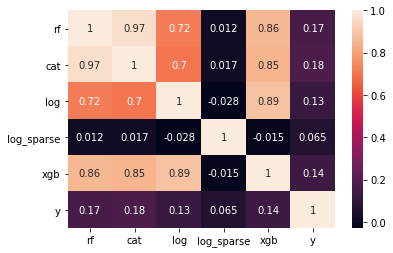

In [74]:
sns.heatmap(cor.corr(), annot = True)

In [54]:
logit2.coef_

array([[3.40530776, 3.81451961, 3.35515492, 2.36029233, 3.35805142]])